# Application Demo

As of October 8th, 2020, all the application functions are packaged in this toolkit. In the following cells, a sample behaviour is shown, where all the toolkit is put to the test.

## Stage 0: Loading all needed data upfront 

In [1]:
%%time

from tfgpkg.preproc.binarize import IlluminationBinarizer
from tfgpkg.preproc.line import LineSegmentation
from tfgpkg.preproc.word import WordSegmentation
from tfgpkg.preproc.paragraph import ParagraphSegmentation
from tfgpkg.recognition.word import RecognitionNet, StringVectorizer, Arch
from tfgpkg.recognition.color import ColorExtractor, ColorGroup
from tfgpkg.recognition import HighlightDetector, TextChecker
from tfgpkg.languages import LanguageTransformer, HTMLMinidownColorListener

from tfgpkg.utils import Printer
from IPython.display import IFrame
from PIL import Image

import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import sys
import cv2
import os

if sys.version_info.minor < 7:
    import importlib_resources as pkg_resources
elif sys.version_info.minor >= 7:
    import pkg_resources
    
plt.rcParams['figure.figsize'] = (10, 9)

Wall time: 3.45 s


## Stage 1: Input & Pre-processing

### Stage 1.1: Load the image & binarize it

Wall time: 1.38 s
Image size: (3595, 2515)


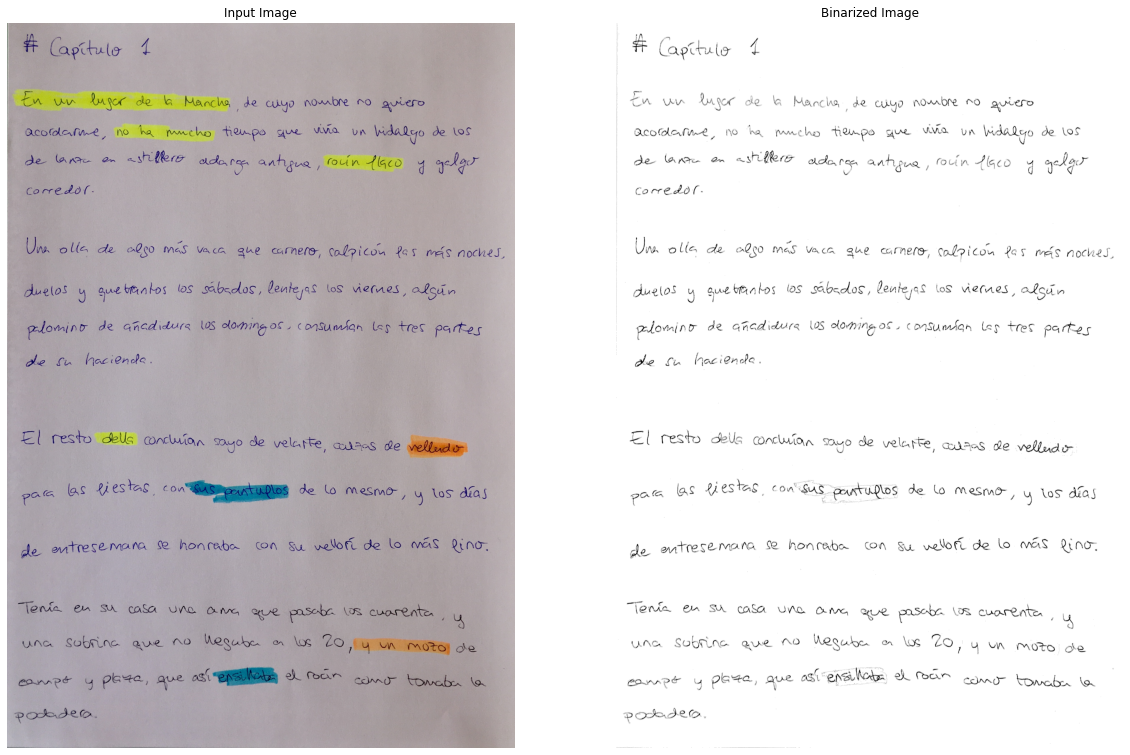

In [65]:
input_image_fpath = "../../data-sources/spanish-words-originals/test2.JPG"
input_image = IlluminationBinarizer.imread(input_image_fpath)

%time bin_image = IlluminationBinarizer.illumination_compensation(input_image, bl=230, iters=1)

print(f"Image size: {bin_image.shape}")

Printer([input_image, bin_image], ["Input Image", "Binarized Image"], (20,15)).print_(flip=True)

In [10]:
save_it = True

if save_it:
    for i, image in enumerate([input_image, bin_image]):
        im = Image.fromarray(image)
        im.save(f"demo_checkpoint0_{i}.png")
else:
    input_image, bin_image = [IlluminationBinarizer.imread(f"demo_checkpoint0_{i}.png", grayscale=gray)
                              for i, gray in [(0, False), (1, True)]]

---

### Stage 1.2.1: Text Segmentation

#### Stage 1.2.1.1: Line segmentation

In [66]:
%time lines = LineSegmentation(bin_image).find_lines()

print(f"Number of lines found: {len(lines)}")

Wall time: 1min 50s
Number of lines found: 20


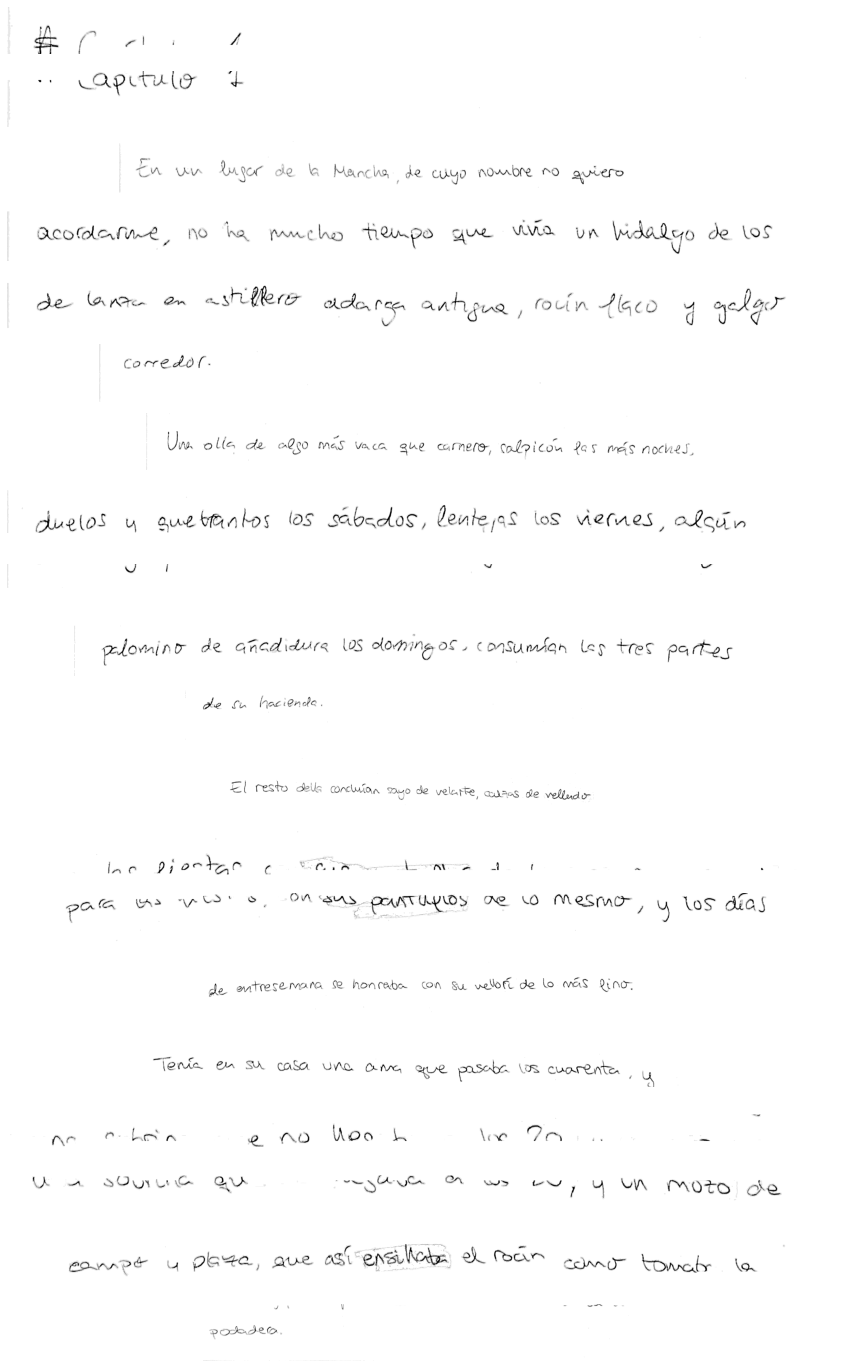

In [67]:
Printer([img for img, _ in lines], None, (15, 25)).print_()

#### Stage 1.2.1.2: Paragraph segmentation

In [ ]:
paragraphs = ParagraphSegmentation(lines)

print([f"Paragraph {i} contains lines {paragraph.get_line_indexes()}" for i, paragraph in enumerate(paragraphs)])

#### Stage 1.2.1.3: Word segmentation

In [87]:
%time words_per_line = [WordSegmentation(line, coords).get_words() for line, coords in lines]

Wall time: 151 ms


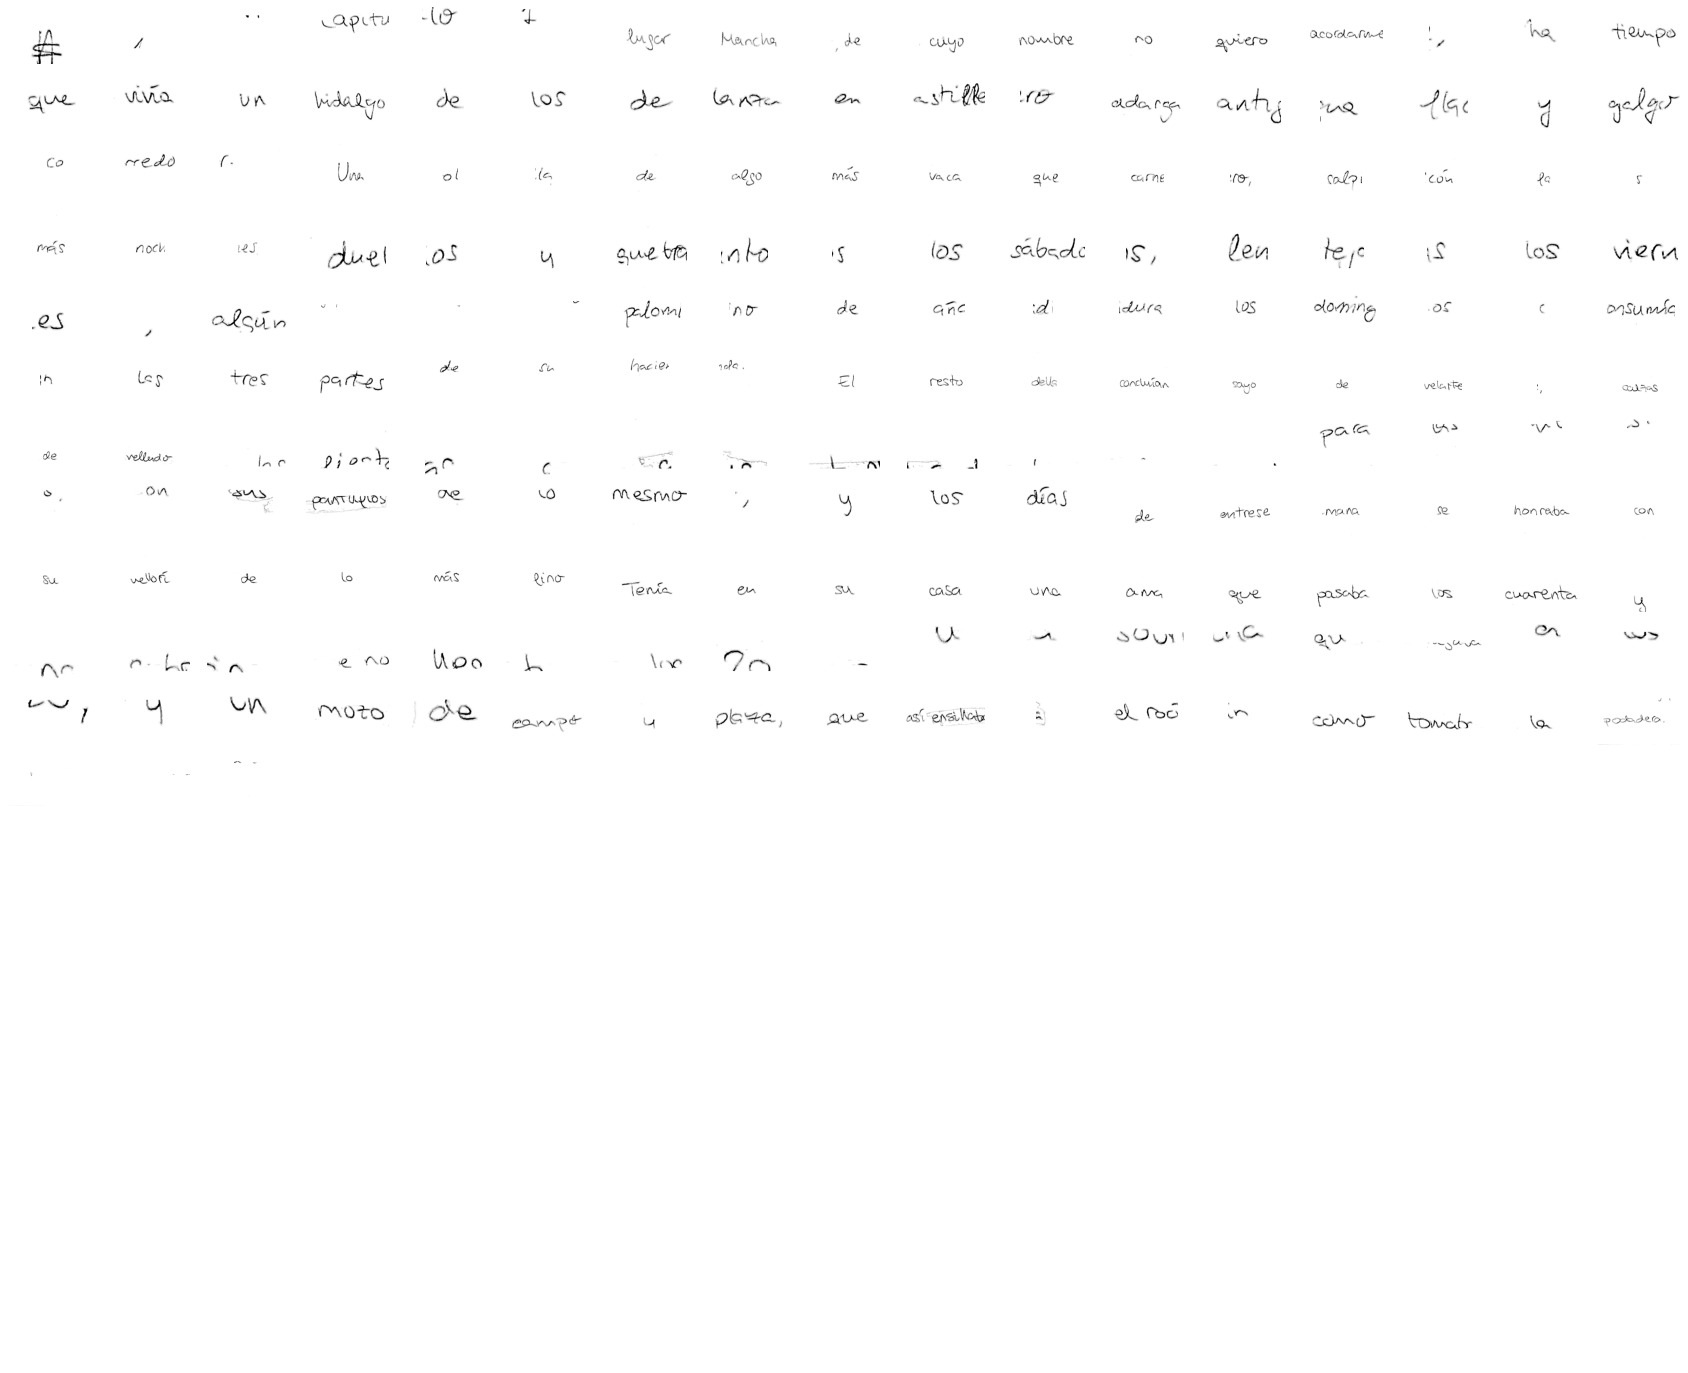

In [132]:
only_words_per_line = [[word for word, _ in line] for line in words_per_line]

Printer(only_words_per_line, figsize=(30, 25)).print_(nested_lists=True)

In [3]:
save_it = True

if save_it:
    demo_checkpoint1 = np.array(words, dtype=object)
    np.save("demo_checkpoint1.npy", demo_checkpoint1)
else:
    words = list(np.load("demo_checkpoint1.npy", allow_pickle=True))

---

## Stage 2: Text & Color Recognition

### Stage 2.1: Text recognition

#### Stage 2.1.1: Text recognition

In [31]:
# set image size and ratio
width, height = TARGET_SIZE = (192, 48)
IMAGE_RATIO = width / height

# get path to saved model
MODEL_PATH = pkg_resources.resource_filename("tfgpkg.recognition.data", "crnn_model_1e_weights.ckpt")

In [27]:
text_net = RecognitionNet(logdir=".", input_size=(*TARGET_SIZE, 1), arch=Arch.Gated)

if os.path.exists(MODEL_PATH):
    text_net.load_chkpt(MODEL_PATH)
else:
    raise ValueError("Path not valid: ", MODEL_PATH)

In [30]:
lines_to_recognize_text = [words[0], words[-2]]

config = {"aspect_ratio": IMAGE_RATIO, "target_size": (width, height)}
processed_lines = [RecognitionNet.preprocess(wrd, **config) for wrd, _ in line for line in lines_to_recognize_text]

OSError: Unable to open file (file signature not found)

In [ ]:
%%time

print("Words to recognize: ", np.product((len(line) for line in lines_to_recognize_text)))

recognized_lines, vectorizer = [], StringVectorizer()
for line in processed_lines:
    preds, _ = text_net.predict(np.array(line))

    recognized_lines.append([vect.decode(pred_word.flatten()) for pred_word in preds])

In [ ]:
longest_line_sz = max([len(line) for line in lines_to_recognize_text])

_, axes = plt.subplots(len(lines_to_recognize_text), longest_line_sz, figsize=(15,7))

for i, line in enumerate(lines_to_recognize_text):       
    for j, (word, _) in enumerate(line):
        recognized_word = recognized_lines[i][j]
        
        axes[i, j].imshow(word, cmap="gray")
        axes[i, j].set_title(recognized_word)
        axes[i, j].axis("off")
        
    for k in range(j, longest_line_sz):
        axes[i, k].axis("off")
    
plt.show()

#### Stage 2.1.2: Spell checking

In [34]:
def get_checked_line(line):
    checked_line = TextChecker([line]).correct()
    print(checked_line)

checked_lines = [get_checked_line(line) for line in lines_to_recognize_text]

Cervantes Garcilaso de la Vega Josep Pla y Will iam Wordsworth


In [16]:
save_it = True

if save_it:
    demo_checkpoint21 = np.array(checked_lines, dtype=object)
    np.save("demo_checkpoint21.npy", demo_checkpoint1)
else:
    checked_lines = list(np.load("demo_checkpoint21.npy"))

C:\Users\Pachacho\miniconda3\envs\tfg\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


---

### Stage 2.2: Color Recognition

#### Stage 2.2.1: Highlight detection

In [4]:
COLOR_TARGET_SIZE = (150, 150)  # by default

In [5]:
color_net = HighlightDetector(target_size=(*COLOR_TARGET_SIZE, 3))
color_net.load_model()

reshape_size = color_net.input_size[:2]

orig_color_words = [input_image[xmin:xmax, ymin:ymax, :] for _, (xmin, ymin, xmax, ymax) in words[-1]]
color_words = (cv2.resize(wrd, reshape_size, cv2.INTER_CUBIC) for wrd in orig_color_words)

color_words = np.array([HighlightDetector.preprocess(wrd, brightness=20, contrast_gain=.05) for wrd in color_words])

In [12]:
print(len(orig_color_words), orig_color_words[0].shape)
print(len(color_words), color_words[0].shape)

5 (296, 386, 3)
5 (150, 150, 3)


In [6]:
preds = color_net.predict(color_words)
pred_class = [HighlightDetector.decode(prediction) for prediction in preds]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


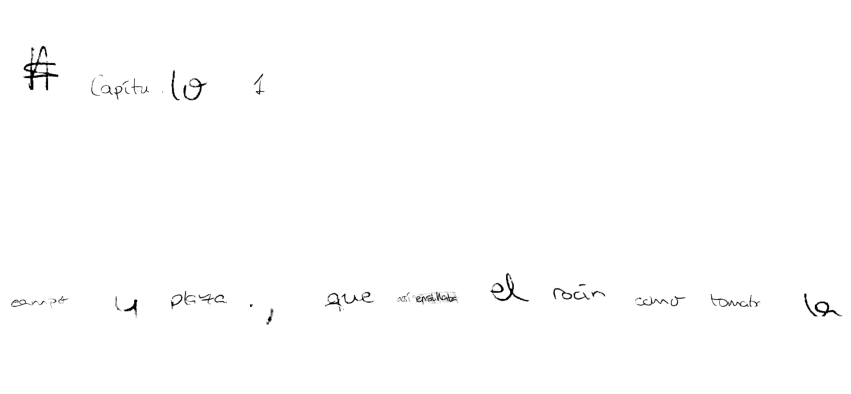

In [7]:
lines_to_print = [words[0], words[-2]]
longest_line_sz = max([len(line) for line in lines_to_print])

_, axes = plt.subplots(len(lines_to_print), longest_line_sz, figsize=(15,7))

for i, line in enumerate(lines_to_print):    
    for j, (word, _) in enumerate(line):
        axes[i, j].imshow(word, cmap="gray")
        axes[i, j].axis("off")
        
    for k in range(j, longest_line_sz):
        axes[i, k].axis("off")
    
plt.show()

In [8]:
color_words_classes = list(zip(color_words, pred_class))

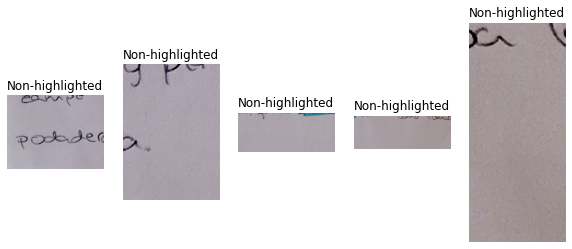

In [136]:
Printer(orig_color_words, pred_class, figsize=(10, 9)).print_(flip=True)

#### Stage 2.2.2: Color extraction

In [16]:
predictor = ColorGroup()

palettes = [ColorExtractor(word).palette(num_colors=3) for word, _ in color_words_classes]

C:\Users\Pachacho\miniconda3\envs\tfg\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
palettes

[[array([[252, 252, 252]]), array([[52, 35, 81]]), array([[172, 156, 204]])],
 [array([[252, 244, 252]]), array([[61, 42, 82]]), array([[212, 196, 228]])],
 [array([[252, 252, 252]]), array([[ 12, 188, 236]]), array([[47, 39, 94]])],
 [array([[252, 236, 244]]), array([[252, 244, 252]]), array([[12,  4,  4]])],
 [array([[252, 244, 244]]), array([[44, 23, 26]]), array([[172, 124, 140]])]]

#### Stage 2.2.3: Color to CSS color names

In [18]:
palettes = [[predictor.predict(color) for color in palette] for palette in palettes]
palettes

[['white', 'purple', 'white'],
 ['white', 'purple', 'white'],
 ['white', 'blue', 'purple'],
 ['white', 'white', 'black'],
 ['white', 'purple', 'purple']]

In [19]:
save_it = True

if save_it:
    demo_checkpoint22 = np.array(palettes)
    np.save("demo_checkpoint22.npy", demo_checkpoint22)
else:
    palettes = list(np.load("demo_checkpoint22.npy"))

## Stage 3: Text Processing

### Stage 3.1: Collect color & text inputs

In [20]:
transformer_input = LanguageTransformer.collect_word_color(palettes, text_output)

[['white', 'purple', 'white'],
 ['white', 'purple', 'white'],
 ['white', 'blue', 'purple'],
 ['white', 'white', 'black'],
 ['white', 'purple', 'purple']]

In [102]:
print(transformer_input)

[('Cervantes', None), ('Garcilaso', None), ('de', None), ('la Vega', None), ('Josep', None), ('Pla', None), ('y', None), ('Will', None), ('iam', None), ('Wordsworth', None)]


### Stage 3.2: Transform the collected input into HTML5

In [13]:
_ = LanguageTransformer(
    listener=HTMLMinidownColorListener,
    text_input=transformer_input,
    output_fpath="demo.html"
)

In [ ]:
save_it = True

if save_it:    
    demo_checkpoint3 = transformer_input
    with open("demo_checkpoint3.pkl", "wb") as f:
        pkl.dump(demo_checkpoint3, f)
else:
    with open("demo_checkpoint3.pkl", "rb") as f:
        transformer_input = pkl.load(f)

# Result

In [14]:
IFrame(src='./demo.html', width=700, height=300)